In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as sig
from scipy.constants import k, pi

In [27]:
rate = 1e6
Tmax = 50
N = int(Tmax*rate)
ADC_max = 1<<13-1
resolution = 1<<14
txgain = 0
ampl = 0.5
dt = T/rate
B = rate/2

In [28]:
T = 8 #Noise Temperature
resistance = 50
sigma = (4*k*T*B*resistance)**0.5 # Variance of the white noise spectrum in Vrms
R = 5.775e-6 #Vrms/ADC
Vmax = ADC_max * R
Vmin = (ADC_max - resolution)*R

In [29]:
t = np.arange(N)*dt
fr = 320e6
# BWfilter = 1/(1 + 2j*B*t)
BWfilter = np.ones_like(t)

In [30]:
noise_real = np.random.randn(N)
noise_real *= (sigma) #Rescale the rv by the variance

noise_imag = np.random.randn(N)
noise_imag *= (sigma) #Rescale the rv by the variance

noise_z = noise_real + 1j*noise_imag

In [31]:
V = (ampl*resolution)*np.ones_like(t, dtype=np.complex128)*R
V *= V
V += noise_z #This should give me a noise time stream like the output of the ADC
V *= BWfilter # Attenuate all fluctuations faster than the bandwidth of the system

In [32]:
# decim = 100
# V = sig.decimate(V, decim, ftype='fir')
# t = t[::100]
# rate /= decim

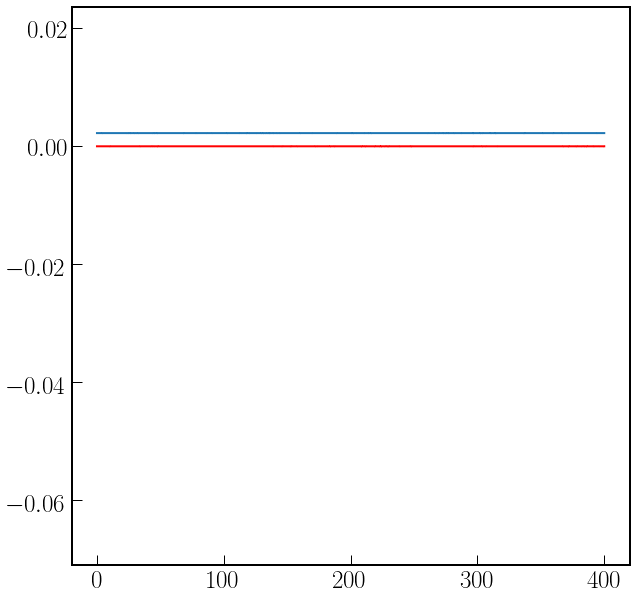

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(t[::100], np.real(V)[::100])
ax.plot(t[::100], np.imag(V)[::100], 'r')
ax.set_ylim((Vmin, Vmax));

In [34]:
# Have the power spectra in Vrms^2/Hz. Do the final conversion
def vrmstodbm(v):
    return 10*np.log10(v**2 * 20)
def dbmtovrms(P):
    return (20*10**(P/10))**0.5

In [35]:
# Now I want the power spectra in dBm/Hz
NPERS_DIV = 512
nperseg = N//NPERS_DIV
z_mean = np.mean(V)
z = V * (np.abs(z_mean)/z_mean)
f, S_real = sig.welch(z.real, nperseg=nperseg, fs=rate, detrend='linear', scaling='density')
f, S_imag = sig.welch(z.imag, nperseg=nperseg, fs=rate, detrend='linear', scaling='density')

Sr_dBm = vrmstodbm(S_real**0.5)
Si_dBm = vrmstodbm(S_imag**0.5)

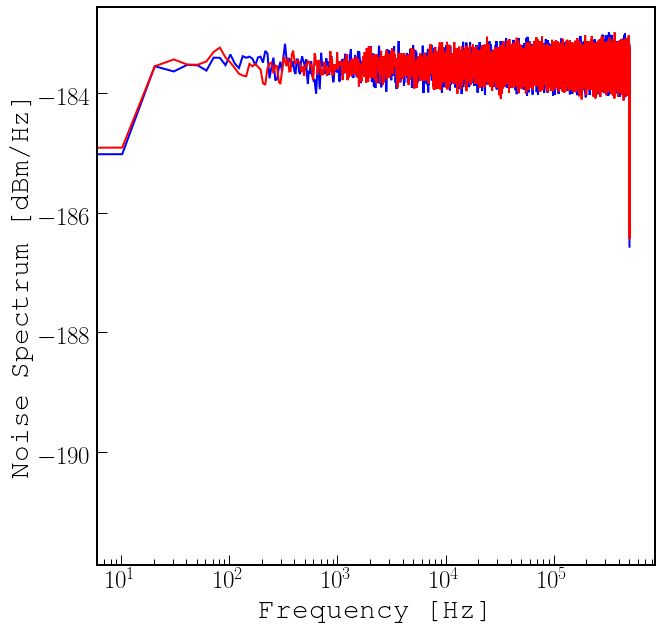

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.semilogx(f, Sr_dBm, 'b')
ax.semilogx(f, Si_dBm, 'r')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Noise Spectrum [dBm/Hz]')
ax.axis('tight');

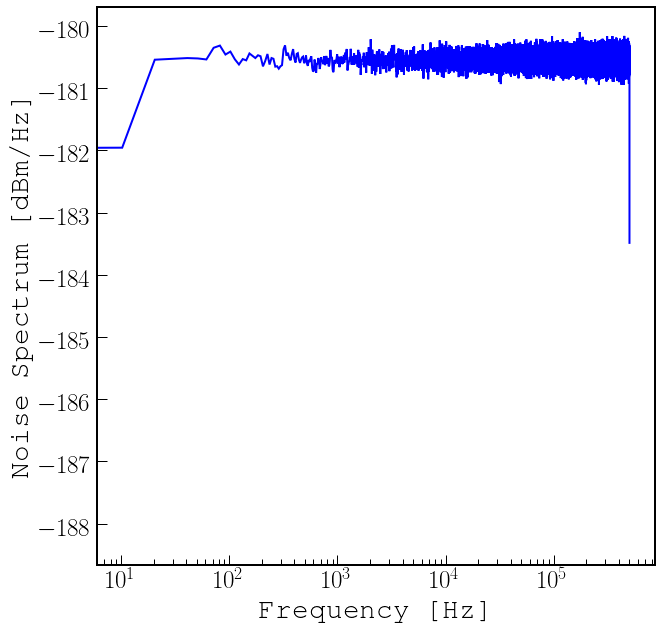

In [37]:
S_total = vrmstodbm((S_real + S_imag)**0.5)
fig, ax = plt.subplots(figsize=(10,10))
ax.semilogx(f, S_total, 'b')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Noise Spectrum [dBm/Hz]')
ax.axis('tight');